# Minimum Spanning Tree

The following is the input to the phylogeny example we saw in class. The distance matrix is given as an edge list and is stored in the csv file '1mst_data.csv'. We will use the __[csv](https://docs.python.org/3/library/csv.html)__ package to use the file. 

Following that, we will store the information into a networkx graph datastructure. The edges will be iterated over the iterator 'datareader', where each 'row' is a list containing the from_edge, to_edge and the value of the distance between them.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import csv
import networkx as nx

G = nx.Graph()
with open('1mst_data.csv', newline='') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        G.add_edge(row[0],row[1],d=float(row[2]))

Let us now plot the input graph $G$.

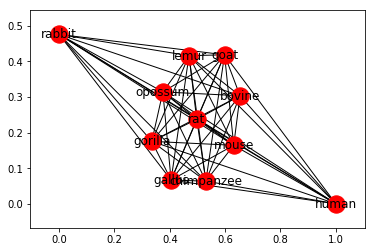

In [2]:
import matplotlib.pyplot as plt

nx.draw_networkx(G,with_labels=True)
plt.show()

Next, we will find the minimum spanning tree $T$ of the graph $G$ and plot it. This will be done using network's inbuilt __[function](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.mst.minimum_spanning_tree.html#networkx.algorithms.mst.minimum_spanning_tree)__, which uses Kruskal's algorithm. Note that the MST we find in this exercise is different from the one in the slides. The one from the slides is taken from another source, which is incorrect.

0.499


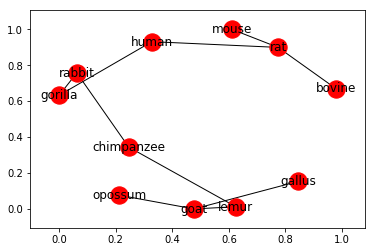

In [3]:
T = nx.minimum_spanning_tree(G,weight = 'd')
print(sum([T[i][j]['d'] for (i,j) in T.edges()]))
nx.draw_networkx(T,with_labels=True)
plt.show()

In [4]:
print("Number of edges in G is",len(G.edges()))
print("Number of edges in T is",len(T.edges()))
print("Is G a tree?",nx.is_tree(G))
print("Is T a tree?",nx.is_tree(T))

Number of edges in G is 66
Number of edges in T is 10
Is G a tree? False
Is T a tree? True


As seen in class, the number of edges in the tree is one less than the number of nodes.

## **Q1. Execute the clustering algorithm desribed in class. For a given value of $k$, find $k$ clusters in the minimum spanning tree.**

Given $n$ nodes (=genes) and distance between all pairs of nodes, the clustering problem aims to partition the nodes into $k$ groups, such that the nodes in the same group are closer compared with nodes in different groups. Consider a
clustering $C = \{C_1, \dots, C_k\}$, where $C$ partitions the nodes into $k$ groups. Then we can formulate the clustering problem as

maximize $D(C)$, where $D(C) = min_{i,j} D(C_i,C_j)$ and $D(C_i,C_j) = min_{u\in C_i, v\in C_j} d(u,v)$

The algorithm must be a function of the minimum spanning tree and $k$. Extract the clusters corresponding to the nodes in the __[connected components](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.components.connected.connected_components.html#networkx.algorithms.components.connected.connected_components)__ of the tree. The input values for $k$ are $\{3,4,5\}$, and the output must of $cluster_k$, which is a list of sets containing the $k$ clusters.

In [5]:
import csv
import networkx as nx

G = nx.Graph()
with open('1mst_data.csv', newline='') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',')
    for row in datareader:
        G.add_edge(row[0],row[1],d=float(row[2]))

T = nx.minimum_spanning_tree(G, 'd')
#  ------- Your code here ---------
def cluster(T,k):
    T_copy = nx.Graph()
    for (i,j) in T.edges():
        T_copy.add_edge(i,j,d=T[i][j]['d'])
    edgelist = [(u,v,T_copy[u][v]['d']) for (u,v) in T_copy.edges()]
    sorted_edgelist = sorted(edgelist, key=lambda x: x[2], reverse = 1)
    most_expensive_edges = sorted_edgelist[:k-1]
    print(sorted_edgelist)
    print(most_expensive_edges)
    for edge in most_expensive_edges:
        T_copy.remove_edge(edge[0],edge[1])
    components = nx.connected_components(T_copy)
    clusters = [i for i in components]
    return clusters
# ----------------
# print('3 clusters = \n',cluster(T,3))
# print('4 clusters = \n',cluster(T,4))
print('5 clusters = \n',cluster(T,5))

[('goat', 'opossum', 0.1584), ('goat', 'gallus', 0.1479), ('rat', 'mouse', 0.0559), ('rat', 'bovine', 0.0468), ('lemur', 'goat', 0.0387), ('human', 'rat', 0.0292), ('chimpanzee', 'lemur', 0.0131), ('gorilla', 'rabbit', 0.008), ('rabbit', 'chimpanzee', 0.0008), ('human', 'gorilla', 0.0002)]
[('goat', 'opossum', 0.1584), ('goat', 'gallus', 0.1479), ('rat', 'mouse', 0.0559), ('rat', 'bovine', 0.0468)]
5 clusters = 
 [{'rat', 'chimpanzee', 'goat', 'gorilla', 'rabbit', 'lemur', 'human'}, {'bovine'}, {'mouse'}, {'gallus'}, {'opossum'}]


## ** Q2. Test the accuracy of clustering algorithm using randomly generated graphs**

We now test the algorithms using randonly generated graphs instances. These instances will follow a __[Stochastic Block Model](https://en.wikipedia.org/wiki/Stochastic_block_model)__. The idea behind SBM is that each instance created will have naturally ocurring clusters, and so it is useful to check to use SBMs to check how well the clustering algorithms can compute the predefined clusters.

Let the number of nodes $N=20$, and let $k=2$. Let nodes labelled $1$ through $10$ be in one cluster, while nodes labelled $11$ to $20$ be in another. We generate graphs such that for every pair of nodes, there exists an edge between them with a certain probability $p$. This probability is as follows: $p_{ij} = \frac{1}{2} + \alpha$ if nodes $i$ and $j$ are in the same cluster; and $\frac{1}{2} - \alpha$ otherwise. Further, we can also define the distance matrix as the following. For every pair of nodes $i$ and $j$, the distance $d_{ij}$ between them is the number of shared neighbors between them. 

The first step is generate the graph using this model. The distances will be stored as an edge attribute to the graph datastructure. The input must be $N$ and $\alpha$. 

In [6]:
import networkx as nx
import random

# --------- Your code here -----------
def generate_graph(N,alpha):
    G2 = nx.Graph()
    G2.add_nodes_from(range(1,N+1))
    for i in G2.nodes():
        for j in G2.nodes():
            if (i in range(1,int(N/2)) and j in range(1,int(N/2))) or (i in range(int(N/2),N+1) and j in range(int(N/2),N+1)):
                if random.uniform(0,1) <= 0.5 + alpha: 
                    G2.add_edge(i,j)
            else:
                if random.uniform(0,1) <= 0.5 - alpha: 
                    G2.add_edge(i,j)
                    
    for (i,j) in G2.edges():
        G2[i][j]['d'] = len(set(G2.neighbors(i)).intersection(set(G2.neighbors(j))))
    return G2
# -----------------------------

Next, generate the Minimum Spanning Tree and run the clustering algorithm in Q1.

In [7]:
G = generate_graph(20,0) # N=20, alpha = 0
T = nx.minimum_spanning_tree(G, 'd')
print(cluster(T,2))

[(1, 12, 11), (4, 5, 10), (16, 20, 10), (4, 7, 9), (4, 9, 9), (4, 13, 9), (4, 19, 9), (1, 6, 9), (11, 17, 9), (4, 1, 8), (4, 10, 8), (4, 14, 8), (16, 3, 8), (16, 18, 8), (1, 2, 8), (11, 8, 8), (4, 15, 7), (4, 16, 7), (16, 11, 7)]
[(1, 12, 11)]
[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20}, {12}]


The accuracy of the clustering algorithm will be measured by the following simple metric. $$\textrm{Accuracy} = \dfrac{\textrm{Number of nodes that are correctly clustered}}{N}.$$

Execute this below. The output must be a number between 0 and 1.

In [8]:
# ----- Your code here ------
def measure_accuracy(clusters,N):
    acc = 0
    for c in clusters:
        for i in c:
            if (1 in c and i <= 10) or (1 not in c and i > 10):
                acc += 1
    return float(acc)/float(N)
# -----------------------

For different values of $\alpha \in \{0,0.125,0.25,0.375,0.5\}$, find the accuracies of the clustering algorithm. Plot the accuracy vs $\alpha$ in a graph.

[(5, 10, 12), (8, 14, 11), (12, 11, 10), (5, 13, 10), (2, 17, 10), (20, 16, 10), (1, 8, 9), (5, 4, 9), (5, 15, 9), (2, 7, 9), (4, 20, 9), (20, 9, 9), (20, 18, 9), (1, 12, 8), (12, 5, 8), (5, 2, 8), (3, 20, 8), (20, 6, 8), (20, 19, 8)]
[(5, 10, 12)]
0.45
[(3, 7, 11), (2, 14, 11), (20, 11, 10), (1, 13, 10), (3, 1, 9), (3, 2, 9), (3, 6, 9), (3, 12, 9), (20, 17, 9), (20, 19, 9), (9, 15, 9), (3, 4, 8), (3, 9, 8), (3, 18, 8), (20, 5, 8), (20, 10, 8), (20, 16, 8), (20, 8, 7), (3, 20, 6)]
[(3, 7, 11)]
0.45
[(4, 5, 8), (5, 14, 8), (5, 10, 8), (1, 18, 8), (20, 2, 8), (12, 7, 8), (10, 9, 8), (4, 3, 7), (16, 1, 7), (18, 8, 7), (8, 15, 7), (4, 13, 6), (6, 20, 6), (1, 12, 6), (8, 19, 6), (3, 11, 5), (17, 6, 4), (3, 16, 4), (4, 17, 3)]
[(4, 5, 8)]
0.4
[(12, 3, 7), (12, 9, 6), (2, 16, 6), (16, 5, 6), (4, 10, 6), (9, 19, 6), (19, 7, 6), (7, 13, 6), (1, 17, 5), (17, 5, 5), (2, 20, 5), (15, 5, 5), (10, 8, 5), (6, 12, 4), (1, 11, 4), (2, 18, 4), (20, 9, 4), (4, 15, 4), (6, 14, 2)]
[(12, 3, 7)]
0.45
[(10, 

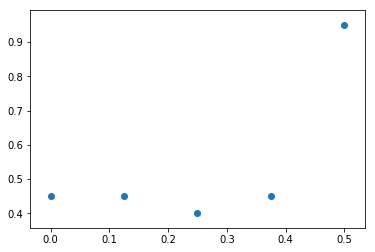

In [10]:
alpha_list = [0,0.125,0.25,0.375,0.5]
acc_list = []
N = 20
# ----- Your code here ------
for alpha in alpha_list:
    G = generate_graph(20,alpha)
    T = nx.minimum_spanning_tree(G, 'd')
    clusters = cluster(T,2)
    acc = measure_accuracy(clusters,N)
    acc_list.append(acc)
    print(acc)
# -----------------------    
plt.scatter(alpha_list, acc_list)
plt.show()